<a href="https://colab.research.google.com/github/magicv711/ERP-Ball-Mapper-Analysis-of-Structural-Dynamics-in-the-UK-Housing-Market/blob/main/ERP_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics

In [ ]:
def prepare_selected_annual_price(df_price_raw):
    # Remove non-LAD (non-local authority district) area codes
    non_lad_codes_to_remove = [
        'E10000003', 'E10000007', 'E10000008', 'E12000004', 'E10000011', 'E12000006',
        'E92000001', 'K04000001', 'E10000012', 'E10000013', 'K03000001', 'E11000001',
        'E10000014', 'E10000015', 'E13000001', 'E10000016', 'E10000017', 'E10000018',
        'E10000019', 'E12000007', 'E11000002', 'E10000020', 'E12000001', 'E12000002',
        'N92000001', 'E10000024', 'E13000002', 'E10000025', 'S92000003', 'E12000008',
        'E12000009', 'E11000003', 'E10000028', 'E10000029', 'E10000030', 'E11000007',
        'K02000001', 'W92000004', 'E10000031', 'E11000005', 'E12000005', 'E10000032',
        'E11000006', 'E10000034', 'E12000003', 'E06000063', 'E06000065', 'E06000064'
    ]
    df_price = df_price_raw[~df_price_raw['AreaCode'].isin(non_lad_codes_to_remove)].copy()

    # Parse dates and extract year
    df_price["Date"] = pd.to_datetime(df_price["Date"], dayfirst=True, errors="coerce")
    df_price = df_price[df_price["Date"].notna()]
    df_price["Year"] = df_price["Date"].dt.year

    # Drop unused columns if present
    df_price = df_price.drop(columns=["IndexSA", "AveragePriceSA"], errors='ignore')

    # Keep only required columns
    selected_cols = [
        "RegionName", "AreaCode", "Year",
        "AveragePrice", "1m%Change", "12m%Change", "SalesVolume",
        "SemiDetachedPrice", "NewPrice", "OldPrice"
    ]
    df_price = df_price[selected_cols].copy()

    # Filter target years
    years_to_extract = [2007, 2008, 2014, 2015, 2019, 2020]
    df_price = df_price[df_price["Year"].isin(years_to_extract)]

    # Aggregate to annual level (mean)
    price_year = (
        df_price
        .groupby(["RegionName", "AreaCode", "Year"])
        .mean(numeric_only=True)
        .reset_index()
    )

    # Round selected numeric columns to 1 decimal (only if the column exists)
    cols_to_round = [
        "AveragePrice", "1m%Change", "12m%Change", "SalesVolume",
        "SemiDetachedPrice", "NewPrice", "OldPrice"
    ]
    for col in cols_to_round:
        if col in price_year.columns:
            price_year[col] = price_year[col].round(1)

    return price_year


In [ ]:
def prepare_income_data(df_income_raw):
    # Filter valid area codes (must start with E, S, W, N)
    df_income = df_income_raw[df_income_raw['LA code'].str.startswith(('E', 'S', 'W', 'N'), na=False)].copy()

    # Keep only selected years
    target_years = [2007, 2008, 2014, 2015, 2019, 2020]
    year_cols = [str(year) for year in target_years]

    for col in year_cols:
        df_income[col] = pd.to_numeric(df_income[col], errors='coerce')

    # Convert to long format (one row per year per region)
    df_income_long = df_income.melt(
        id_vars=['LA code', 'LA name'],
        value_vars=year_cols,
        var_name='Year',
        value_name='Income'
    )
    df_income_long['Year'] = pd.to_numeric(df_income_long['Year'], errors='coerce')

    # Rename columns to match house price table
    df_income_long = df_income_long.rename(columns={
        'LA code': 'AreaCode',
        'LA name': 'RegionName'
    })

    # Reorder columns
    df_income_long = df_income_long[['RegionName', 'AreaCode', 'Year', 'Income']]

    return df_income_long


In [ ]:

data = pd.read_csv('/content/income data.csv')

In [ ]:
df_price_raw = pd.read_csv("/content/house price data.csv")
price_year = prepare_selected_annual_price(df_price_raw)
price_year

,RegionName,AreaCode,Year,AveragePrice,1m%Change,12m%Change,SalesVolume,SemiDetachedPrice,NewPrice,OldPrice
0,Aberdeenshire,S12000034,2007,167845.2,1.8,27.6,516.7,145561.5,218891.5,161613.5
1,Aberdeenshire,S12000034,2008,179441.2,0.1,7.5,383.3,157182.4,236504.0,172388.3
2,Aberdeenshire,S12000034,2014,199781.1,0.7,7.6,486.0,174790.7,269926.8,191773.1
3,Aberdeenshire,S12000034,2015,207355.6,-0.1,4.0,424.8,181954.9,279709.8,199095.9
4,Aberdeenshire,S12000034,2019,190988.8,-0.2,-2.5,339.8,168766.4,267031.5,182920.0
...,...,...,...,...,...,...,...,...,...,...
2137,York,E06000014,2008,183766.2,-1.2,-5.0,189.0,188301.8,196204.0,182342.5
2138,York,E06000014,2014,199576.1,0.6,6.7,313.5,206556.7,211568.8,198679.1
2139,York,E06000014,2015,214080.6,0.5,7.3,294.3,221795.5,228076.8,212991.0
2140,York,E06000014,2019,248339.8,0.0,2.6,270.0,260652.6,272745.3,247236.1


In [ ]:

df_income_raw = pd.read_csv("income data.csv")
income_year = prepare_income_data(df_income_raw)
merged = pd.merge(price_year, income_year, on=['RegionName', 'AreaCode', 'Year'], how='left')
merged = merged[~merged['AreaCode'].str.startswith('N09')]
price_year = price_year[~price_year['AreaCode'].str.startswith('N09')]



In [ ]:
merged

,RegionName,AreaCode,Year,AveragePrice,1m%Change,12m%Change,SalesVolume,SemiDetachedPrice,NewPrice,OldPrice,Income
0,Aberdeenshire,S12000034,2007,167845.2,1.8,27.6,516.7,145561.5,218891.5,161613.5,17485.0
1,Aberdeenshire,S12000034,2008,179441.2,0.1,7.5,383.3,157182.4,236504.0,172388.3,18400.0
2,Aberdeenshire,S12000034,2014,199781.1,0.7,7.6,486.0,174790.7,269926.8,191773.1,22492.0
3,Aberdeenshire,S12000034,2015,207355.6,-0.1,4.0,424.8,181954.9,279709.8,199095.9,22715.0
4,Aberdeenshire,S12000034,2019,190988.8,-0.2,-2.5,339.8,168766.4,267031.5,182920.0,23089.0
...,...,...,...,...,...,...,...,...,...,...,...
2071,York,E06000014,2008,183766.2,-1.2,-5.0,189.0,188301.8,196204.0,182342.5,14956.0
2072,York,E06000014,2014,199576.1,0.6,6.7,313.5,206556.7,211568.8,198679.1,17466.0
2073,York,E06000014,2015,214080.6,0.5,7.3,294.3,221795.5,228076.8,212991.0,18276.0
2074,York,E06000014,2019,248339.8,0.0,2.6,270.0,260652.6,272745.3,247236.1,20213.0


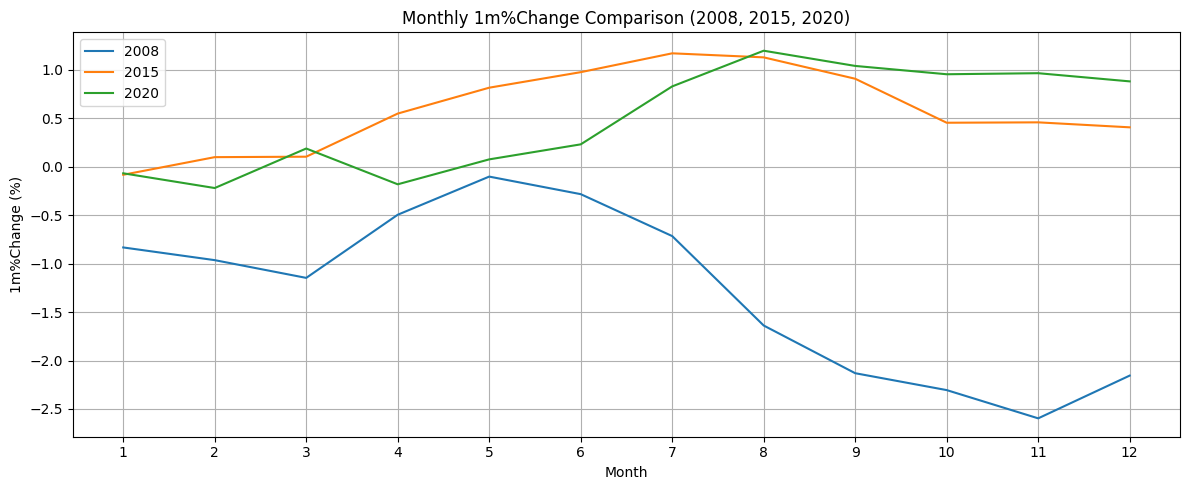

In [ ]:
plt.figure(figsize=(12, 5))

for year in [2008, 2015, 2020]:
    df_year = df[df["Year"] == year]
    monthly_avg = df_year.groupby("Month")["1m%Change"].mean()
    plt.plot(monthly_avg.index, monthly_avg.values, label=str(year))

plt.xlabel("Month")
plt.ylabel("1m%Change (%)")
plt.title("Monthly 1m%Change Comparison (2008, 2015, 2020)")
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


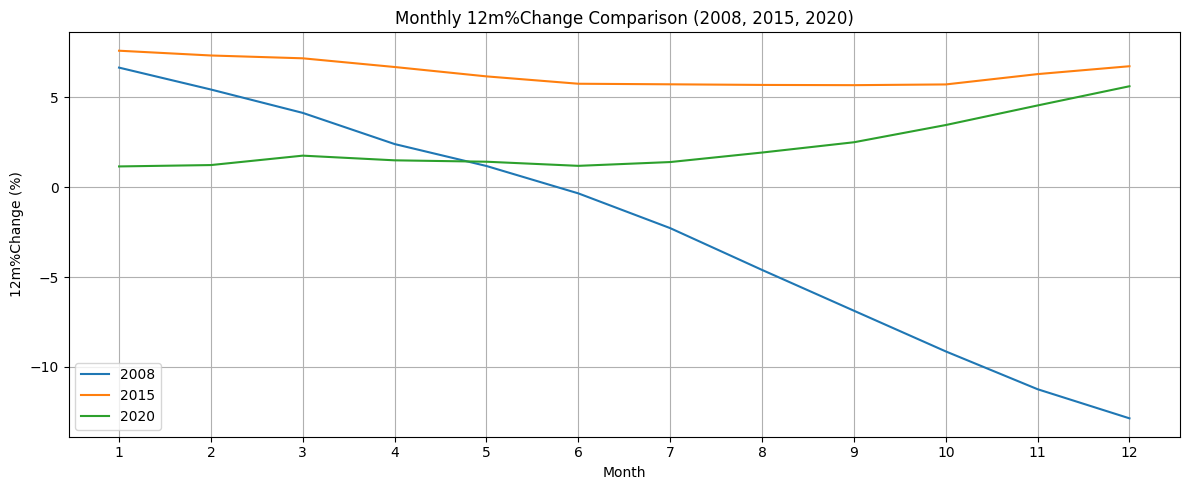

In [ ]:
plt.figure(figsize=(12, 5))

for year in [2008, 2015, 2020]:
    df_year = df[df["Year"] == year]
    monthly_avg = df_year.groupby("Month")["12m%Change"].mean()
    plt.plot(monthly_avg.index, monthly_avg.values, label=str(year))

plt.xlabel("Month")
plt.ylabel("12m%Change (%)")
plt.title("Monthly 12m%Change Comparison (2008, 2015, 2020)")
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


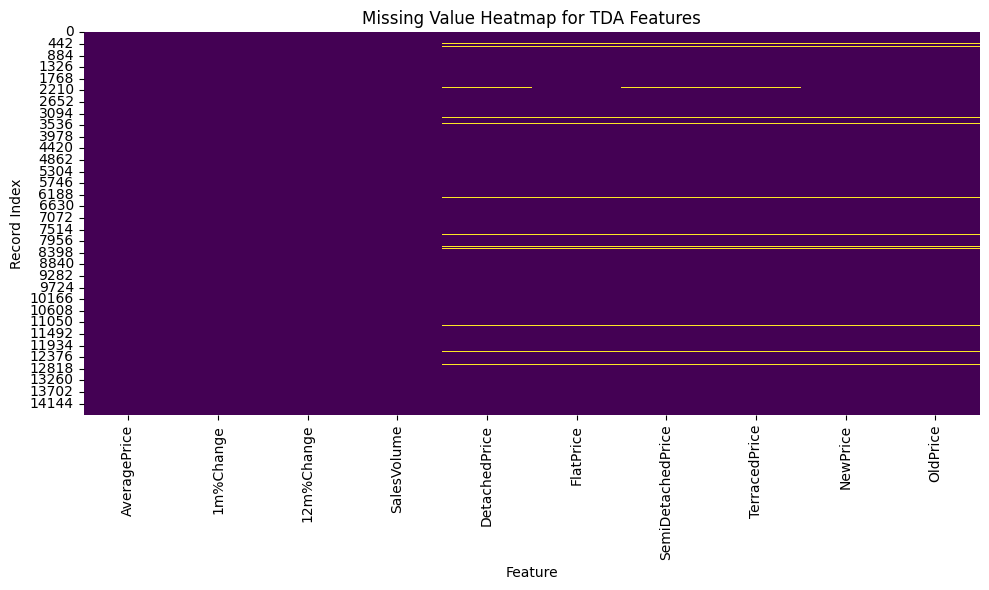

In [ ]:


features = [
    "AveragePrice", "1m%Change", "12m%Change", "SalesVolume",
    "DetachedPrice", "FlatPrice", "SemiDetachedPrice", "TerracedPrice",
    "NewPrice", "OldPrice"
]

plt.figure(figsize=(10, 6))
sns.heatmap(df[features].isnull(), cbar=False, cmap="viridis")
plt.title("Missing Value Heatmap for TDA Features")
plt.xlabel("Feature")
plt.ylabel("Record Index")
plt.tight_layout()
plt.show()


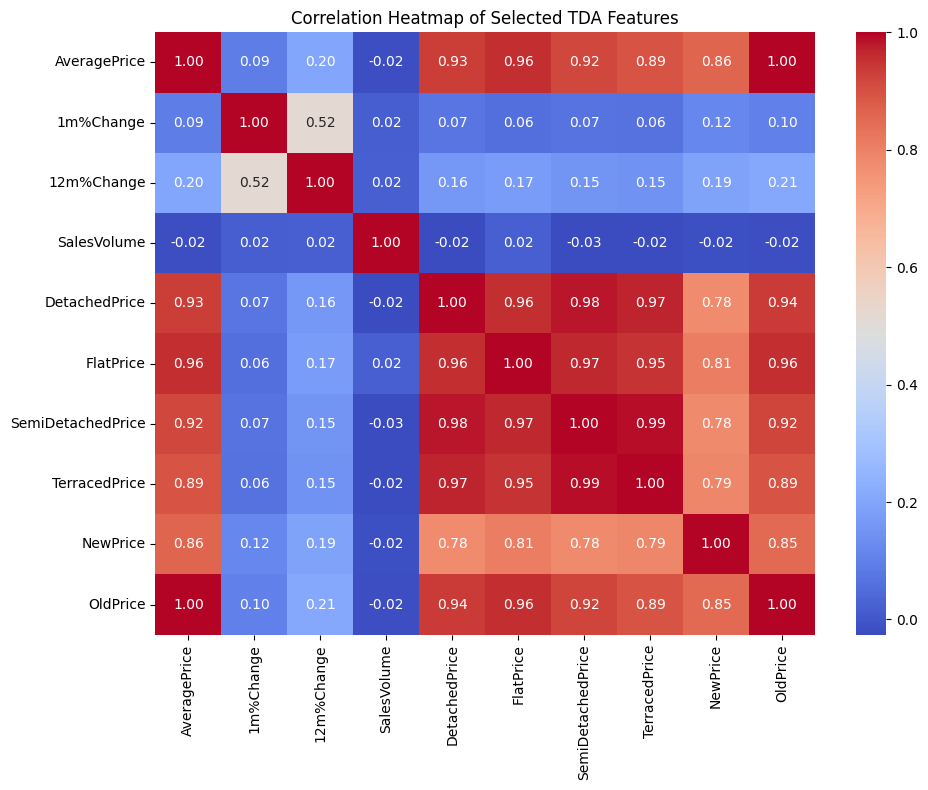

In [ ]:
plt.figure(figsize=(10, 8))
corr = df[features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Selected TDA Features")
plt.tight_layout()
plt.show()


# Other variables processing

In [ ]:
import pandas as pd

# 1. Read file into df_variables
df_variables = pd.read_excel("/content/Other variables.xlsx")

# 2. Drop columns containing 'Conf', 'Numerator', or 'Denominator'
cols_to_drop = [col for col in df_variables.columns if any(key in str(col) for key in ['Conf', 'Numerator', 'Denominator'])]
df_variables = df_variables.drop(columns=cols_to_drop)

# 3. Define rename mapping: original column name -> simplified name
rename_dict = {
    'Employment rate - aged 16-64': 'EmploymentRate_16_64',
    'Unemployment rate - aged 16-64': 'UnemploymentRate_16_64',
    'Unemployment rate - aged 16+': 'UnemploymentRate_16plus',
    '% aged 16-64 who are self employed': 'SelfEmployed_16_64',
    '% aged 16-64 who are employees': 'Employees_16_64',
    'Economic activity rate - aged 16-64': 'EconActiveRate_16_64',
    '% with RQF4+ - aged 16-64': 'Education_RQF4plus',
    '% with no qualifications (RQF) - aged 16-64': 'NoQual_16_64',
    '% of economically inactive who want a job': 'Inactive_WantJob',
    '% of economically inactive who do not want a job': 'Inactive_NoJob',
    # Add more columns if needed
}

# 4. Identify value columns to keep
value_cols = [col for col in df_variables.columns if col in rename_dict]

# 5. Keep base columns + selected value columns
base_cols = ['local authority: district / unitary (as of April 2023)', 'mnemonic', 'year']
df_variables = df_variables[base_cols + value_cols]

# 6. Rename columns to simplified names
df_variables = df_variables.rename(columns=rename_dict)
df_variables = df_variables.rename(columns={
    'local authority: district / unitary (as of April 2023)': 'RegionName',
    'mnemonic': 'RegionCode'
})

# 7. Preview result
print(df_variables.head())


             RegionName RegionCode  year EconActiveRate_16_64  \
0            Hartlepool  E06000001  2007                 71.7   
1         Middlesbrough  E06000002  2007                 70.2   
2  Redcar and Cleveland  E06000003  2007                 72.7   
3      Stockton-on-Tees  E06000004  2007                 74.9   
4            Darlington  E06000005  2007                 76.7   

  EmploymentRate_16_64 Employees_16_64 SelfEmployed_16_64  \
0                 63.9            56.7                6.6   
1                 65.4            59.6                4.8   
2                 67.8            63.4                3.9   
3                 70.2            63.6                5.7   
4                 71.9              65                6.6   

  UnemploymentRate_16_64 UnemploymentRate_16plus Inactive_WantJob  \
0                   10.9                    10.8             26.5   
1                    6.8                     6.9             17.8   
2                    6.7           

In [ ]:
import numpy as np

# Custom cleaning function: handle special symbols
def clean_special_values(value):
    if isinstance(value, str):
        value = value.strip()
        if value in ['#', '!', '*', '~', '-']:
            return np.nan  # set as missing
        try:
            return float(value)  # convert to numeric if possible
        except ValueError:
            return np.nan
    return value

# Apply cleaning to value columns (exclude region, code, year)
value_columns = [col for col in df_variables.columns if col not in ['RegionName', 'RegionCode', 'year']]
df_variables[value_columns] = df_variables[value_columns].applymap(clean_special_values)

# Count missing values per column
missing_summary = df_variables.isna().sum().sort_values(ascending=False)

# Display top 10 variables with most missing values
print(missing_summary.head(10))


Education_RQF4plus         3150
NoQual_16_64               3150
UnemploymentRate_16_64      318
UnemploymentRate_16plus     306
Inactive_WantJob            164
SelfEmployed_16_64           23
Inactive_NoJob               16
EmploymentRate_16_64         10
EconActiveRate_16_64         10
Employees_16_64              10
RegionCode                    0
RegionName                    0
year                          0
dtype: int64


<ipython-input-12-3737558938>:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_variables[value_columns] = df_variables[value_columns].applymap(clean_special_values)


In [ ]:
df_variables = df_variables.drop(columns=["Education_RQF4plus", "NoQual_16_64"], errors="ignore")


In [ ]:

year_data = pd.merge(
    merged,
    df_variables,
    left_on=["AreaCode", "Year"],
    right_on=["RegionCode", "year"],
    how="left"
)


year_data = year_data.drop(columns=["RegionCode", "year"], errors="ignore")


In [ ]:
year_data

,RegionName_x,AreaCode,Year,AveragePrice,1m%Change,12m%Change,SalesVolume,SemiDetachedPrice,NewPrice,OldPrice,Income,RegionName_y,EconActiveRate_16_64,EmploymentRate_16_64,Employees_16_64,SelfEmployed_16_64,UnemploymentRate_16_64,UnemploymentRate_16plus,Inactive_WantJob,Inactive_NoJob
0,Aberdeenshire,S12000034,2007,167845.2,1.8,27.6,516.7,145561.5,218891.5,161613.5,17485.0,Aberdeenshire,82.2,80.5,69.5,10.4,2.1,2,23,77
1,Aberdeenshire,S12000034,2008,179441.2,0.1,7.5,383.3,157182.4,236504.0,172388.3,18400.0,Aberdeenshire,82.5,80.2,69.3,10.5,2.7,2.7,33.2,66.8
2,Aberdeenshire,S12000034,2014,199781.1,0.7,7.6,486.0,174790.7,269926.8,191773.1,22492.0,Aberdeenshire,84.2,80.9,70.4,10.1,4,3.9,28.7,71.3
3,Aberdeenshire,S12000034,2015,207355.6,-0.1,4.0,424.8,181954.9,279709.8,199095.9,22715.0,Aberdeenshire,82.6,80.6,71,8.8,2.4,2.3,35.8,64.2
4,Aberdeenshire,S12000034,2019,190988.8,-0.2,-2.5,339.8,168766.4,267031.5,182920.0,23089.0,Aberdeenshire,83,80.8,70.3,10.3,2.7,2.7,23,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,York,E06000014,2008,183766.2,-1.2,-5.0,189.0,188301.8,196204.0,182342.5,14956.0,York,79.9,76.5,68.3,7.8,4.2,4.1,13.5,86.5
2072,York,E06000014,2014,199576.1,0.6,6.7,313.5,206556.7,211568.8,198679.1,17466.0,York,76,72.8,65.6,6.6,4.1,4,20.6,79.4
2073,York,E06000014,2015,214080.6,0.5,7.3,294.3,221795.5,228076.8,212991.0,18276.0,York,79.9,76.4,67.7,8.5,4.3,4.3,23.7,76.3
2074,York,E06000014,2019,248339.8,0.0,2.6,270.0,260652.6,272745.3,247236.1,20213.0,York,81.3,79.2,69.9,9.1,2.6,2.6,14.2,85.8


In [ ]:
def prepare_multi_year_population(df_raw):
    df_raw.columns = df_raw.columns.str.strip()

    # 提取所有年份人口字段
    pop_cols = [col for col in df_raw.columns if "Population" in col and "Mid-" in col]
    area_col = "Area Sq Km"
    code_col = "LAD 2021 Code"

    # 将 Area 和 LAD 代码保留，加上每年的人口列
    df = df_raw[[code_col, area_col] + pop_cols].copy()

    # 聚合：按 LAD 聚合面积和人口
    df_grouped = df.groupby(code_col).agg({area_col: "sum", **{col: "sum" for col in pop_cols}}).reset_index()

    # 生成长表结构（Year, Population, Density）
    df_long = df_grouped.melt(
        id_vars=[code_col, area_col],
        value_vars=pop_cols,
        var_name="YearLabel",
        value_name="Population"
    )

    # 提取年份数值
    df_long["Year"] = df_long["YearLabel"].str.extract(r"Mid-(\d{4})").astype(int)

    # 计算密度
    df_long["PeoplePerSqKm"] = df_long["Population"] / df_long[area_col]

    # 标准列名
    df_long = df_long.rename(columns={
        code_col: "AreaCode",
        area_col: "TotalArea"
    })

    # 最终保留字段
    df_long = df_long[["AreaCode", "Year", "Population", "TotalArea", "PeoplePerSqKm"]]

    return df_long


In [ ]:
df_pop_raw = pd.read_excel("/content/population1.xlsx")

In [ ]:
pop_multi_year = prepare_multi_year_population(df_pop_raw)
pop_multi_year

,AreaCode,Year,Population,TotalArea,PeoplePerSqKm
0,E06000001,2014,92358,93.6994,985.684007
1,E06000002,2014,139030,53.8799,2580.368560
2,E06000003,2014,135106,245.0757,551.282726
3,E06000004,2014,195113,204.9434,952.033586
4,E06000005,2014,105825,197.4751,535.890348
...,...,...,...,...,...
1981,W06000020,2022,92863,125.6414,739.111471
1982,W06000021,2022,93985,849.2022,110.674466
1983,W06000022,2022,161565,190.4260,848.439814
1984,W06000023,2022,133874,5180.6023,25.841397


In [ ]:
def prepare_multi_year_population(df_raw):
    df_raw.columns = df_raw.columns.str.strip()

    # Identify population columns for all years
    pop_cols = [col for col in df_raw.columns if "Population" in col and "Mid-" in col]
    area_col = "Area Sq Km"
    code_col = "LAD 2021 Code"

    # Keep LAD code, area, and population columns
    df = df_raw[[code_col, area_col] + pop_cols].copy()

    # Aggregate area and population by LAD code
    df_grouped = df.groupby(code_col).agg({area_col: "sum", **{col: "sum" for col in pop_cols}}).reset_index()

    # Convert to long format (Year, Population, Density)
    df_long = df_grouped.melt(
        id_vars=[code_col, area_col],
        value_vars=pop_cols,
        var_name="YearLabel",
        value_name="Population"
    )

    # Extract year from column labels
    df_long["Year"] = df_long["YearLabel"].str.extract(r"Mid-(\d{4})").astype(int)

    # Calculate population density
    df_long["PeoplePerSqKm"] = df_long["Population"] / df_long[area_col]

    # Standardize column names
    df_long = df_long.rename(columns={
        code_col: "AreaCode",
        area_col: "TotalArea"
    })

    # Keep final columns
    df_long = df_long[["AreaCode", "Year", "Population", "TotalArea", "PeoplePerSqKm"]]

    return df_long


In [ ]:
df_early_raw = pd.read_excel("/content/population2.xlsx")
early_pop = prepare_early_population(df_early_raw)


In [ ]:

all_pop = pd.concat([early_pop, pop_multi_year], ignore_index=True)

all_pop = all_pop.drop_duplicates(subset=['AreaCode', 'Year'], keep='last')


In [ ]:
year_data = pd.merge(year_data, all_pop, on=["AreaCode", "Year"], how="left")


In [ ]:
year_data

,RegionName_x,AreaCode,Year,AveragePrice,1m%Change,12m%Change,SalesVolume,SemiDetachedPrice,NewPrice,OldPrice,...,EmploymentRate_16_64,Employees_16_64,SelfEmployed_16_64,UnemploymentRate_16_64,UnemploymentRate_16plus,Inactive_WantJob,Inactive_NoJob,Population,TotalArea,PeoplePerSqKm
0,Aberdeenshire,S12000034,2007,167845.2,1.8,27.6,516.7,145561.5,218891.5,161613.5,...,80.5,69.5,10.4,2.1,2,23,77,NaN,NaN,NaN
1,Aberdeenshire,S12000034,2008,179441.2,0.1,7.5,383.3,157182.4,236504.0,172388.3,...,80.2,69.3,10.5,2.7,2.7,33.2,66.8,NaN,NaN,NaN
2,Aberdeenshire,S12000034,2014,199781.1,0.7,7.6,486.0,174790.7,269926.8,191773.1,...,80.9,70.4,10.1,4,3.9,28.7,71.3,NaN,NaN,NaN
3,Aberdeenshire,S12000034,2015,207355.6,-0.1,4.0,424.8,181954.9,279709.8,199095.9,...,80.6,71,8.8,2.4,2.3,35.8,64.2,NaN,NaN,NaN
4,Aberdeenshire,S12000034,2019,190988.8,-0.2,-2.5,339.8,168766.4,267031.5,182920.0,...,80.8,70.3,10.3,2.7,2.7,23,77,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,York,E06000014,2008,183766.2,-1.2,-5.0,189.0,188301.8,196204.0,182342.5,...,76.5,68.3,7.8,4.2,4.1,13.5,86.5,716.527514,271.98816,2.634407
2072,York,E06000014,2014,199576.1,0.6,6.7,313.5,206556.7,211568.8,198679.1,...,72.8,65.6,6.6,4.1,4,20.6,79.4,202206.000000,271.93580,743.579918
2073,York,E06000014,2015,214080.6,0.5,7.3,294.3,221795.5,228076.8,212991.0,...,76.4,67.7,8.5,4.3,4.3,23.7,76.3,203212.000000,271.93580,747.279321
2074,York,E06000014,2019,248339.8,0.0,2.6,270.0,260652.6,272745.3,247236.1,...,79.2,69.9,9.1,2.6,2.6,14.2,85.8,203877.000000,271.93580,749.724751


In [ ]:

income_year_avg = year_data.groupby("Year")["Income"].mean()


year_data["Income"] = year_data.apply(
    lambda row: income_year_avg[row["Year"]] if pd.isna(row["Income"]) else row["Income"],
    axis=1
)


In [ ]:

year_data.to_csv('year_data_cleaned.csv', index=False)


#check code


In [ ]:
import pandas as pd

print("--- Comparing differences between AreaCode and df_variables['RegionCode'] ---")

# 1. Values in merged['AreaCode'] but not in df_variables['RegionCode']
area_not_in_variable = merged[~merged['AreaCode'].isin(df_variables['RegionCode'])]['AreaCode'].unique()
print(f"\nValues in merged['AreaCode'] but not in df_variables['RegionCode']:\n{area_not_in_variable}")

# 2. Values in df_variables['RegionCode'] but not in merged['AreaCode']
code_not_in_price = df_variables[~df_variables['RegionCode'].isin(merged['AreaCode'])]['RegionCode'].unique()
print(f"\nValues in df_variables['RegionCode'] but not in merged['AreaCode']:\n{code_not_in_price}")

# 3. Set-based comparison for unique differences
set_area = set(merged['AreaCode'].unique())
set_code = set(df_variables['RegionCode'].unique())

only_in_merged = set_area - set_code
only_in_variables = set_code - set_area

print(f"\nUnique to merged['AreaCode']:\n{only_in_merged}")
print(f"\nUnique to df_variables['RegionCode']:\n{only_in_variables}")


--- AreaCode 与 df_variables['RegionCode'] 的数据差异分析 ---

在 merged['AreaCode'] 中存在，但 df_variables['RegionCode'] 中不存在的值:
[]

在 df_variables['RegionCode'] 中存在，但 merged['AreaCode'] 中不存在的值:
['E06000063' 'E06000064' 'E06000065' 'E06000053']

仅在 merged['AreaCode'] 中的值:
set()

仅在 df_variables['RegionCode'] 中的值:
{'E06000065', 'E06000053', 'E06000063', 'E06000064'}
